In [70]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("zalando-research/fashionmnist")

print("Path to dataset files:", path)

Path to dataset files: /home/rahovegas/.cache/kagglehub/datasets/zalando-research/fashionmnist/versions/4


In [71]:
import numpy as np
import pandas as pd
import os
import pickle

%matplotlib inline
import matplotlib.pyplot as plt

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import VarianceThreshold
from sklearn.model_selection import train_test_split

from skimage.transform import resize
from skimage.feature import hog

In [72]:
train_path = path + "/fashion-mnist_train.csv"
test_path = path + "/fashion-mnist_test.csv"

train_data = pd.read_csv(train_path)
test_data = pd.read_csv(test_path)

(train_imgs, train_labels) = (train_data.iloc[:, 1:].values.reshape(-1, 28, 28).astype('uint8'), train_data.iloc[:, 0].values)

(test_imgs, test_labels) = (test_data.iloc[:, 1:].values.reshape(-1, 28, 28).astype('uint8'), test_data.iloc[:, 0].values)

In [26]:
class DataProcessing:
	def __init__(self, train_data, test_data):
		self.train_data = train_data
		self.test_data = test_data

	def extract_PCA_features(self, imgs, n_components):
		scaler = StandardScaler()
		flatten_imgs = scaler.fit_transform([i.flatten() for i in imgs])
		pca = PCA(n_components=n_components)
		
		principal_components = pca.fit_transform(flatten_imgs)
		imgs_reduced = pca.inverse_transform(principal_components).reshape(-1, 28, 28)
		
		return principal_components, imgs_reduced
	
	def extract_HOG_features(self, imgs, hog_path, n_bins=9):
		if os.path.exists(hog_path):
			return pickle.load(open(hog_path + '/hog_features.pkl', 'rb'))
		
		os.makedirs(hog_path)

		fds = []

		idx = 0

		for img in imgs:
			img_resized = resize(img, (128, 64))
			fd, hog_img = hog(img_resized, orientations=n_bins, pixels_per_cell=(8, 8), cells_per_block=(2, 2), visualize=True)
			hog_img = resize(hog_img, (28, 28))
			
			pickle.dump(hog_img, open(hog_path + '/hog_img_{}.pkl'.format(idx), 'wb'))
			fds.append(fd)

			idx += 1

		pickle.dump(fds, open(hog_path + '/hog_features.pkl', 'wb'))
		
		return np.array(fds)

	def collect_and_transform_data(self):
		scaler = StandardScaler()

		train_pca, train_pca_reduced = self.extract_PCA_features(train_imgs, 20)
		
		test_pca, test_pca_reduced = self.extract_PCA_features(test_imgs, 20)

		train_hog = self.extract_HOG_features(train_imgs, './hog_train')

		test_hog = self.extract_HOG_features(test_imgs, './hog_test')

		X_train = np.concatenate((train_pca, train_hog), axis=1)
		X_test = np.concatenate((test_pca, test_hog), axis=1)

		print("Number of extracted features after PCA and HOG:", X_train.shape[1])

		sel = VarianceThreshold(threshold=.935 * (1 - .935))
		X_train = sel.fit_transform(X_train)
		X_test = sel.transform(X_test)

		X_train = scaler.fit_transform(X_train)
		X_test = scaler.transform(X_test)

		print("Number of extracted features after variance threshold:", X_train.shape[1])

		return X_train, X_test, train_labels, test_labels

In [27]:
X_train, X_test, y_train, y_test = DataProcessing(train_imgs, test_imgs).collect_and_transform_data()

Number of extracted features after PCA and HOG: 3800
Number of extracted features after variance threshold: 63


In [73]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset

import torchvision
from torchvision import datasets, transforms

In [74]:
class CustomDataset(Dataset):
	def __init__(self, X, y, transform=None):
		self.X = X
		self.y = y
		self.transform = transform

	def __len__(self):
		return len(self.X)

	def __getitem__(self, idx):
		image = self.X[idx]
		label = self.y[idx]

		if self.transform:
			image = self.transform(image)
		else:
			image = torch.tensor(image, dtype=torch.float32)
			
		label = torch.tensor(label, dtype=torch.long)

		return image, label

In [75]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [76]:
def train_epoch(model, dataloader, device, optimizer, criterion, epoch, lr_scheduler=None):
	model.train()

	train_loss = 0.0
	correct = 0
	dataset_size = 0

	for step, (images, labels) in enumerate(dataloader):
		images = images.to(device)
		labels = labels.to(device)

		optimizer.zero_grad()

		pred = model(images)
		loss = criterion(pred, labels)

		predicted = torch.argmax(pred, 1)
		correct += (predicted == labels).sum().item()
		dataset_size += labels.size(0)

		loss.backward()
		optimizer.step()
		if lr_scheduler:
			lr_scheduler.step()

		train_loss += loss.item()

	train_loss /= dataset_size
	accuracy = correct / dataset_size

	return train_loss, accuracy

In [77]:
def valid_epoch(model, dataloader, device, criterion,epoch):
	model.eval()

	valid_loss = 0.0
	correct = 0
	dataset_size = 0

	for step, (images, labels) in enumerate(dataloader):
		images = images.to(device)
		labels = labels.to(device)

		pred = model(images)
		loss = criterion(pred, labels)

		valid_loss += loss.item()

		predicted = torch.argmax(pred, dim=1)
		correct += (predicted == labels).sum().item()
		dataset_size += labels.size(0)

	valid_loss /= dataset_size
	accuracy = correct / dataset_size

	return valid_loss, accuracy

In [78]:
def plot_loss(train_losses, test_accuracy, title):
	plt.plot(train_losses, label='Training loss')
	plt.plot(test_accuracy, label='Test loss')
	plt.legend()
	plt.xlabel('Epoch')
	plt.ylabel('Loss')
	plt.title(title)
	plt.show()

In [79]:
def plot_accuracy(train_accuracy, test_accuracy, title):
	plt.plot(train_accuracy, label='Training accuracy')
	plt.plot(test_accuracy, label='Test accuracy')
	plt.legend()
	plt.xlabel('Epoch')
	plt.ylabel('Accuracy')
	plt.title(title)
	plt.show()

In [80]:
def run_training(model, criterion, optimizer, num_epochs, lr_scheduler=None):
	training_losses = []
	train_accs = []

	test_losses = []
	test_accs = []

	for epoch in range(num_epochs):
		train_loss, train_acc = train_epoch(model, train_loader, device, optimizer, criterion, epoch, lr_scheduler)
	
		training_losses.append(train_loss)
		train_accs.append(train_acc)

		with torch.no_grad():
			test_loss, test_acc = valid_epoch(model, test_loader, device, criterion, epoch)

			test_losses.append(test_loss)
			test_accs.append(test_acc)

			print('Epoch: {} Train Loss: {:.4f} Train Acc: {:.4f} Test Loss: {:.4f} Test Acc: {:.4f}'.format(epoch, train_loss, train_acc, test_loss, test_acc))
	
	plot_loss(training_losses, test_losses, "Loss")
	plot_accuracy(train_accs, test_accs, "Accuracy")
	return training_losses, test_losses, train_accs, test_accs

In [36]:
class FeatureMLPNet(nn.Module):
	def __init__(self):
		super(FeatureMLPNet, self).__init__()
		self.fc1 = nn.Linear(in_features=63, out_features=128)
		self.fc2 = nn.Linear(in_features=128, out_features=256)
		self.fc3 = nn.Linear(in_features=256, out_features=10)

		self.relu = nn.ReLU()

		self.dropout = nn.Dropout(p=0.2)

	def forward(self, x):
		x = self.fc1(x)
		x = self.relu(x)
		x = self.dropout(x)
		x = self.fc2(x)
		x = self.relu(x)
		x = self.dropout(x)
		x = self.fc3(x)
		
		return x


In [37]:
transform = transforms.Compose([
	transforms.ToTensor(),
	transforms.Normalize((0.5,), (0.5,))
])

In [38]:
training_data = CustomDataset(X_train, y_train)
testing_data = CustomDataset(X_test, y_test)

train_loader = DataLoader(training_data, batch_size=256, shuffle=True)
test_loader = DataLoader(testing_data, batch_size=256, shuffle=True)

Epoch: 0 Train Loss: 0.0029 Train Acc: 0.7428 Test Loss: 0.0024 Test Acc: 0.7742
Epoch: 1 Train Loss: 0.0019 Train Acc: 0.8210 Test Loss: 0.0022 Test Acc: 0.7875
Epoch: 2 Train Loss: 0.0018 Train Acc: 0.8335 Test Loss: 0.0022 Test Acc: 0.7932
Epoch: 3 Train Loss: 0.0017 Train Acc: 0.8423 Test Loss: 0.0022 Test Acc: 0.7915
Epoch: 4 Train Loss: 0.0016 Train Acc: 0.8480 Test Loss: 0.0022 Test Acc: 0.7902
Epoch: 5 Train Loss: 0.0016 Train Acc: 0.8525 Test Loss: 0.0021 Test Acc: 0.7928
Epoch: 6 Train Loss: 0.0015 Train Acc: 0.8557 Test Loss: 0.0022 Test Acc: 0.7976
Epoch: 7 Train Loss: 0.0015 Train Acc: 0.8576 Test Loss: 0.0022 Test Acc: 0.7899
Epoch: 8 Train Loss: 0.0015 Train Acc: 0.8600 Test Loss: 0.0022 Test Acc: 0.7867
Epoch: 9 Train Loss: 0.0014 Train Acc: 0.8619 Test Loss: 0.0021 Test Acc: 0.7884


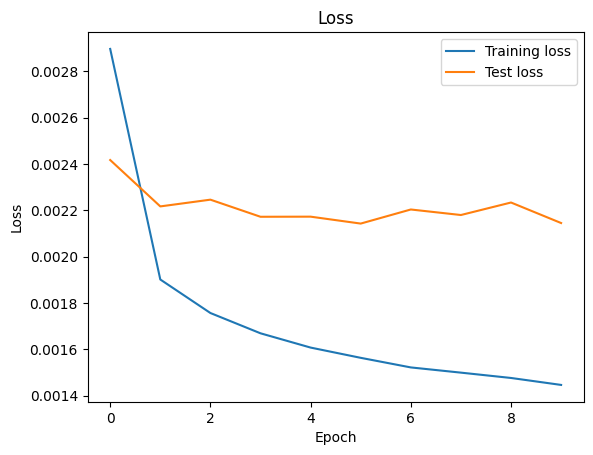

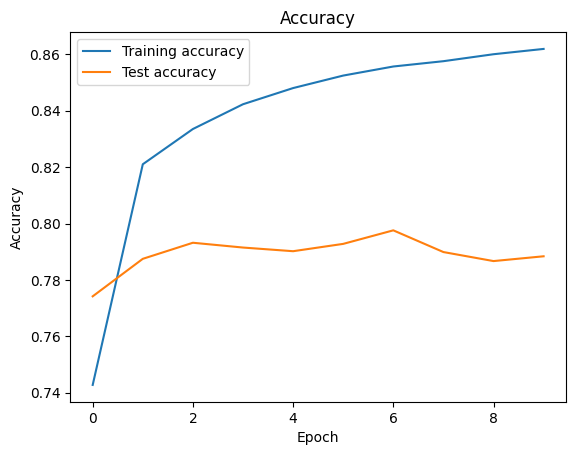

([0.002897138247390588,
  0.0019012340366840364,
  0.0017564469113945961,
  0.0016688125019272168,
  0.0016071606213847796,
  0.0015628822157780328,
  0.0015214439531167348,
  0.0014989123220245043,
  0.0014758968497316043,
  0.0014458578263719876],
 [0.002417207637429237,
  0.0022168964505195616,
  0.0022460545063018797,
  0.0021721481770277024,
  0.0021726179480552675,
  0.002142761355638504,
  0.002203606840968132,
  0.0021797272861003875,
  0.0022337372332811357,
  0.0021451183706521987],
 [0.7427833333333334,
  0.8210333333333333,
  0.8335333333333333,
  0.8423166666666667,
  0.84805,
  0.8524833333333334,
  0.8557,
  0.8575833333333334,
  0.86005,
  0.8619333333333333],
 [0.7742,
  0.7875,
  0.7932,
  0.7915,
  0.7902,
  0.7928,
  0.7976,
  0.7899,
  0.7867,
  0.7884])

In [39]:
model = FeatureMLPNet()
model.to(device)

learning_rate = 0.001
epochs = 10

criterion = nn.CrossEntropyLoss()

optimizer = optim.Adam(model.parameters(), lr=learning_rate)

run_training(model, criterion, optimizer, epochs)

In [40]:
class DirectMLPNet(nn.Module):
	def __init__(self):
		super(DirectMLPNet, self).__init__()
		
		self.fc1 = nn.Linear(in_features=784, out_features=256)
		self.fc2 = nn.Linear(in_features=256, out_features=128)
		self.fc3 = nn.Linear(in_features=128, out_features=100)
		self.fc4 = nn.Linear(in_features=100, out_features=10)

		self.relu = nn.ReLU()

		self.dropout = nn.Dropout(p=0.2)

	def forward(self, x):
		x = x.view(x.size(0), -1)
		x = self.fc1(x)
		x = self.relu(x)
		x = self.dropout(x)
		x = self.fc2(x)
		x = self.relu(x)
		x = self.dropout(x)
		x = self.fc3(x)
		x = self.relu(x)
		x = self.dropout(x)
		x = self.fc4(x)
		
		return x

In [41]:
training_data = CustomDataset(train_imgs, train_labels, transform=transform)
testing_data = CustomDataset(test_imgs, test_labels, transform=transform)

train_loader = DataLoader(training_data, batch_size=256, shuffle=True)
test_loader = DataLoader(testing_data, batch_size=256, shuffle=True)

Epoch: 0 Train Loss: 0.0027 Train Acc: 0.7452 Test Loss: 0.0018 Test Acc: 0.8420
Epoch: 1 Train Loss: 0.0018 Train Acc: 0.8386 Test Loss: 0.0015 Test Acc: 0.8634
Epoch: 2 Train Loss: 0.0016 Train Acc: 0.8562 Test Loss: 0.0014 Test Acc: 0.8669
Epoch: 3 Train Loss: 0.0015 Train Acc: 0.8656 Test Loss: 0.0014 Test Acc: 0.8695
Epoch: 4 Train Loss: 0.0014 Train Acc: 0.8722 Test Loss: 0.0013 Test Acc: 0.8798


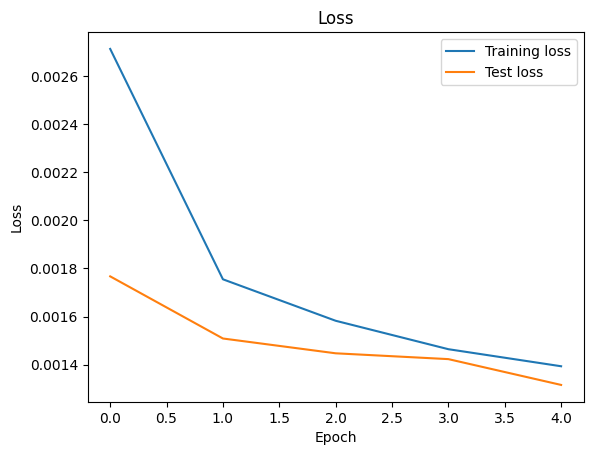

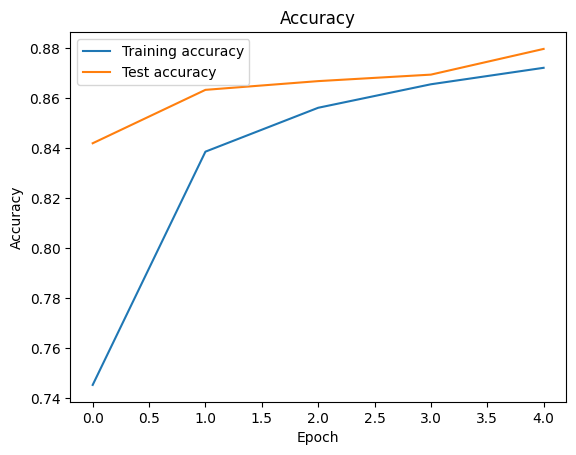

([0.002711709690093994,
  0.0017546038091182708,
  0.0015822993675867717,
  0.0014641610647241274,
  0.0013933195389807225],
 [0.0017667736411094666,
  0.0015086228311061859,
  0.0014471226185560227,
  0.001422934240102768,
  0.0013157497763633729],
 [0.7451666666666666,
  0.8386333333333333,
  0.8562166666666666,
  0.8656333333333334,
  0.8722333333333333],
 [0.842, 0.8634, 0.8669, 0.8695, 0.8798])

In [42]:
model = DirectMLPNet()
model.to(device)

learning_rate = 0.001
epochs = 5

criterion = nn.CrossEntropyLoss()

optimizer = optim.Adam(model.parameters(), lr=learning_rate)

run_training(model, criterion, optimizer, epochs)

In [81]:
transform = transforms.Compose([
	transforms.ToTensor(),
	transforms.Resize((32, 32)),
	transforms.Normalize((0.5,), (0.5,))
])

In [82]:
class EmptyNorm(nn.Module):
    def __init__(self, *args, **kwargs):
        super(EmptyNorm, self).__init__()
        self._modules = dict()
    
    def forward(self, input):
        return input

In [83]:
def conv3x3(in_planes, out_planes, stride=1, padding=1):
    """
    3x3 2D convolution with padding=1
    @:param in_planes: the number of input channels for the convolution filter
    @:param out_planes: the number of output channels for the convolution filter
    @:param stride: stride value for the convolution filter, default is 1
    @:param padding: the padding to apply, default is 1 to keep width and height the same in the output activation maps 
    """
    return nn.Conv2d(in_planes, out_planes, kernel_size=3, stride=stride,
                     padding=padding, bias=False)


def conv1x1(in_planes, out_planes, stride=1):
    """
    1x1 2D convolution
    @:param in_planes: the number of input channels for the convolution filter
    @:param out_planes: the number of output channels for the convolution filter
    @:param stride: stride value for the convolution filter, default is 1
    """
    return nn.Conv2d(in_planes, out_planes, kernel_size=1, stride=stride, bias=False)


In [84]:
class ConvBlock(nn.Module):
    def __init__(self, bottleneck_channels, block_channels, norm_layer=nn.BatchNorm2d):
        super(ConvBlock, self).__init__()

        # first conv 1x1 layer which implements the bottlenecking
        self.conv1 = conv1x1(block_channels, bottleneck_channels)
        self.norm1 = norm_layer(bottleneck_channels)

        # conv 3x3 layer which applies the stride given as parameter
        self.conv2 = conv3x3(bottleneck_channels, bottleneck_channels)
        self.norm2 = norm_layer(bottleneck_channels)

        # conv 1x1 layer where the number of output channels is "expanded" according to the defined expansion factor
        # according to the above figure, the expansion factor is set to 4
        self.conv3 = conv1x1(bottleneck_channels, block_channels)
        self.norm3 = norm_layer(block_channels)

        self.relu = nn.ReLU(inplace=True)

    def forward(self, x):
        identity = x

        # first layer conv1 + bn1 + relu
        out = self.conv1(x)
        out = self.norm1(out)
        out = self.relu(out)

        # second layer conv2 + bn2 + relu
        out = self.conv2(out)
        out = self.norm2(out)
        out = self.relu(out)

        # third layer conv3 + bn3
        out = self.conv3(out)
        out = self.norm3(out)

        # add identity to residual and apply relu
        out += identity
        out = self.relu(out)

        return out

In [85]:
class DeepConvNet(nn.Module):
    def __init__(self, norm_layer=nn.BatchNorm2d, base_depth=16, expansion=4, nr_layer_blocks=3, num_classes=10):
        super(DeepConvNet, self).__init__()

        self.norm_layer = norm_layer

        self.base_depth = base_depth
        self.conv1 = nn.Conv2d(1, self.base_depth, kernel_size=7, stride=2, padding=3,
                               bias=False)  # image is now 16x16
        self.norm1 = norm_layer(self.base_depth)
        self.relu = nn.ReLU(inplace=True)

        # change to 64 channels base and image size 16x16
        depth1 = self.base_depth * expansion
        self.conv_depth1 = conv1x1(self.base_depth, depth1, stride=1)
        self.norm_depth1 = norm_layer(depth1)

        # #### Layer 1, 3 blocks
        self.layer1 = nn.Sequential(
            *[ConvBlock(self.base_depth, depth1, norm_layer=self.norm_layer)] * nr_layer_blocks
        )

        # change to 128 channels base and image size 8x8
        depth2 = depth1 * 2
        # TODO 3.1 - Definiti convolutia 2D cu kernel de dimensiune 1x1 care injumatateste imaginea
        self.conv_depth2 = conv1x1(depth1, depth2, stride=2)
        self.norm_depth2 = norm_layer(depth2)

        # #### Layer 2, 3 blocks
        # TODO 3.2 - Definiti secventa de ConvBlocks pentru Layer 2
        self.layer2 = nn.Sequential(
            *[ConvBlock(depth1, depth2, norm_layer=self.norm_layer)] * nr_layer_blocks
        )

        # change to 256 chanels and image size 4x4
        depth3 = depth2 * 2
        # TODO 3.3 - Definiti convolutia 2D cu kernel de dimensiune 1x1 care injumatateste imaginea
        self.conv_depth3 = conv1x1(depth2, depth3, stride=2)
        self.norm_depth3 = norm_layer(depth3)

        # Layer 3, 3 blocks
        # TODO 3.4 - Definiti secventa de ConvBlocks pentru Layer 3
        self.layer3 = nn.Sequential(
            *[ConvBlock(depth2, depth3, norm_layer=self.norm_layer)] * nr_layer_blocks
        )

        # AveragePooling
        # TODO 3.5 - Definiti straturile de GlobalAveragePooling si stratul Fully Connected
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(depth3, num_classes)


    def forward(self, x):
        # initial conv
        x = self.conv1(x)
        x = self.norm1(x)
        x = self.relu(x)

        # TODO 3.6 apply depth1 transform + layer 1
        x = self.conv_depth1(x)
        x = self.norm_depth1(x)
        x = self.relu(x)
        x = self.layer1(x)      

        # TODO 3.7 apply depth2 transform + layer 2
        x = self.conv_depth2(x)
        x = self.norm_depth2(x)
        x = self.relu(x)
        x = self.layer2(x)

        # TODO 3.8 apply depth3 transform + layer 3
        x = self.conv_depth3(x)
        x = self.norm_depth3(x)
        x = self.relu(x)
        x = self.layer3(x)
        
        # apply global average pooling + linearize + FC
        x = self.avgpool(x)

        x = x.view(x.size(0), -1)

        x = self.fc(x)

        return x

In [86]:
training_data = CustomDataset(train_imgs, train_labels, transform=transform)
testing_data = CustomDataset(test_imgs, test_labels, transform=transform)

train_loader = DataLoader(training_data, batch_size=256, shuffle=True)
test_loader = DataLoader(testing_data, batch_size=256, shuffle=True)

Epoch: 0 Train Loss: 0.0020 Train Acc: 0.8085 Test Loss: 0.0019 Test Acc: 0.8182
Epoch: 1 Train Loss: 0.0013 Train Acc: 0.8756 Test Loss: 0.0038 Test Acc: 0.6423
Epoch: 2 Train Loss: 0.0011 Train Acc: 0.8937 Test Loss: 0.0014 Test Acc: 0.8721
Epoch: 3 Train Loss: 0.0010 Train Acc: 0.9036 Test Loss: 0.0015 Test Acc: 0.8659
Epoch: 4 Train Loss: 0.0009 Train Acc: 0.9126 Test Loss: 0.0024 Test Acc: 0.7818
Epoch: 5 Train Loss: 0.0008 Train Acc: 0.9200 Test Loss: 0.0017 Test Acc: 0.8383
Epoch: 6 Train Loss: 0.0008 Train Acc: 0.9233 Test Loss: 0.0016 Test Acc: 0.8577
Epoch: 7 Train Loss: 0.0007 Train Acc: 0.9290 Test Loss: 0.0025 Test Acc: 0.7952
Epoch: 8 Train Loss: 0.0007 Train Acc: 0.9328 Test Loss: 0.0017 Test Acc: 0.8484
Epoch: 9 Train Loss: 0.0007 Train Acc: 0.9372 Test Loss: 0.0016 Test Acc: 0.8606
Epoch: 10 Train Loss: 0.0006 Train Acc: 0.9422 Test Loss: 0.0021 Test Acc: 0.8284
Epoch: 11 Train Loss: 0.0006 Train Acc: 0.9454 Test Loss: 0.0013 Test Acc: 0.8890
Epoch: 12 Train Loss: 0.00

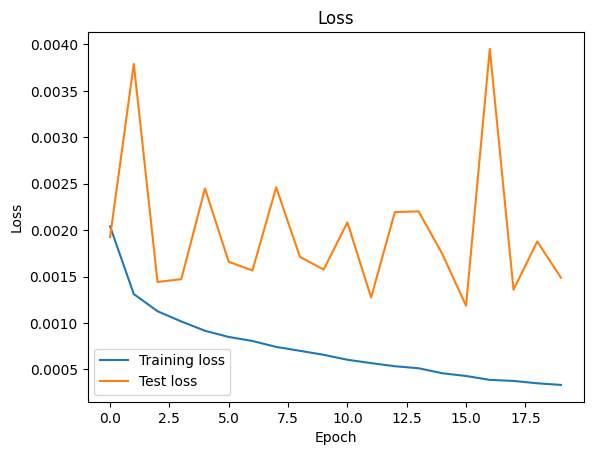

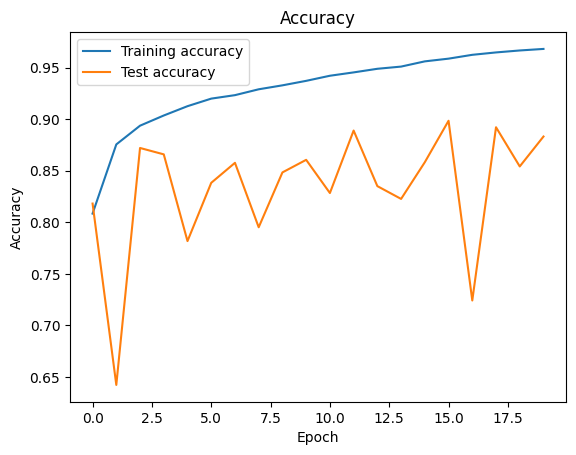

In [87]:
model = DeepConvNet()
model.to(device)

learning_rate = 0.001
epochs = 20

criterion = nn.CrossEntropyLoss()

optimizer = optim.Adam(model.parameters(), lr=learning_rate)

no_aug_train_loss, no_aug_test_loss, no_aug_train_acc, no_aug_test_acc = run_training(model, criterion, optimizer, epochs)

In [88]:
hard_transform = transforms.Compose([
	transforms.ToTensor(),
	transforms.Resize((32, 32)),
	transforms.RandomHorizontalFlip(),
	transforms.RandomRotation(10),
	transforms.RandomCrop(32, padding=int(32*0.125), padding_mode='reflect'),
	transforms.Normalize((0.5,), (0.5,))
])

In [89]:
training_data = CustomDataset(train_imgs, train_labels, transform=hard_transform)
testing_data = CustomDataset(test_imgs, test_labels, transform=transform)

train_loader = DataLoader(training_data, batch_size=256, shuffle=True)
test_loader = DataLoader(testing_data, batch_size=256, shuffle=True)

Epoch: 0 Train Loss: 0.0029 Train Acc: 0.7157 Test Loss: 0.0040 Test Acc: 0.6277
Epoch: 1 Train Loss: 0.0020 Train Acc: 0.8025 Test Loss: 0.0071 Test Acc: 0.5128
Epoch: 2 Train Loss: 0.0018 Train Acc: 0.8298 Test Loss: 0.0025 Test Acc: 0.7625
Epoch: 3 Train Loss: 0.0017 Train Acc: 0.8422 Test Loss: 0.0020 Test Acc: 0.8047
Epoch: 4 Train Loss: 0.0015 Train Acc: 0.8541 Test Loss: 0.0018 Test Acc: 0.8310
Epoch: 5 Train Loss: 0.0015 Train Acc: 0.8606 Test Loss: 0.0017 Test Acc: 0.8314
Epoch: 6 Train Loss: 0.0014 Train Acc: 0.8658 Test Loss: 0.0021 Test Acc: 0.8111
Epoch: 7 Train Loss: 0.0014 Train Acc: 0.8712 Test Loss: 0.0016 Test Acc: 0.8555
Epoch: 8 Train Loss: 0.0013 Train Acc: 0.8730 Test Loss: 0.0019 Test Acc: 0.8207
Epoch: 9 Train Loss: 0.0013 Train Acc: 0.8772 Test Loss: 0.0015 Test Acc: 0.8616
Epoch: 10 Train Loss: 0.0013 Train Acc: 0.8797 Test Loss: 0.0016 Test Acc: 0.8490
Epoch: 11 Train Loss: 0.0012 Train Acc: 0.8813 Test Loss: 0.0013 Test Acc: 0.8751
Epoch: 12 Train Loss: 0.00

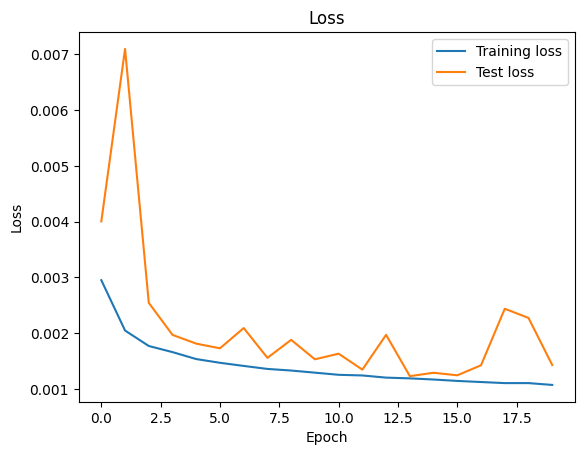

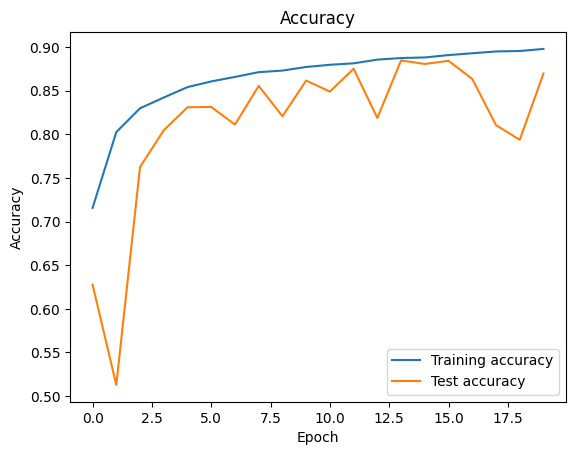

In [90]:
model = DeepConvNet()
model.to(device)

learning_rate = 0.001
epochs = 20

criterion = nn.CrossEntropyLoss()

optimizer = optim.Adam(model.parameters(), lr=learning_rate)

aug_train_loss, aug_test_loss, aug_train_acc, aug_test_acc = run_training(model, criterion, optimizer, epochs)

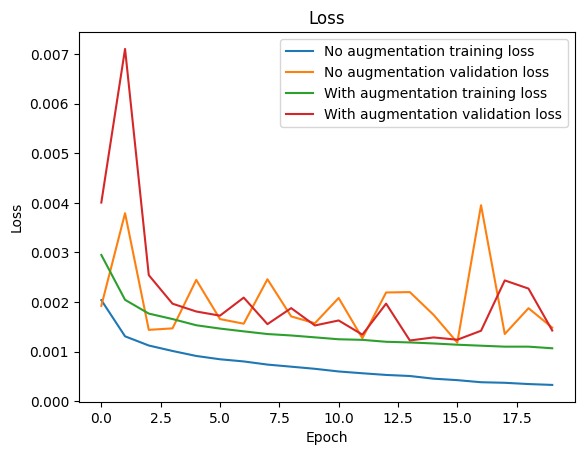

In [91]:
plt.plot(no_aug_train_loss, label='No augmentation training loss')
plt.plot(no_aug_test_loss, label='No augmentation validation loss')
plt.plot(aug_train_loss, label='With augmentation training loss')
plt.plot(aug_test_loss, label='With augmentation validation loss')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title("Loss")
plt.show()

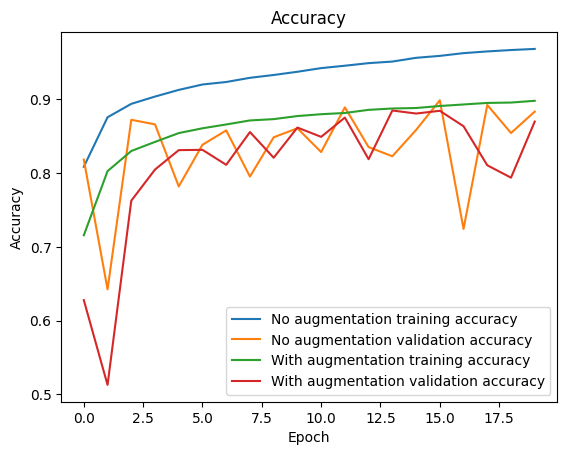

In [92]:
plt.plot(no_aug_train_acc, label='No augmentation training accuracy')
plt.plot(no_aug_test_acc, label='No augmentation validation accuracy')
plt.plot(aug_train_acc, label='With augmentation training accuracy')
plt.plot(aug_test_acc, label='With augmentation validation accuracy')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title("Accuracy")
plt.show()

In [93]:
resnet_transform = transforms.Compose([
	transforms.ToTensor(),
	transforms.Resize((32, 32)),
	transforms.Grayscale(num_output_channels=3),
	transforms.Normalize((0.5,), (0.5,))
])

In [94]:
train_3d_imgs = []

for img in train_imgs:
	train_3d_imgs.append(np.stack((img,)*3, axis=-1))

test_3d_imgs = []
for img in test_imgs:
	test_3d_imgs.append(np.stack((img,)*3, axis=-1))

In [95]:
training_data = CustomDataset(train_3d_imgs, train_labels, transform=resnet_transform)
testing_data = CustomDataset(test_3d_imgs, test_labels, transform=resnet_transform)

train_loader = DataLoader(training_data, batch_size=64, shuffle=True)
test_loader = DataLoader(testing_data, batch_size=64, shuffle=True)

/home/rahovegas/.local/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/rahovegas/.local/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch: 0 Train Loss: 0.0066 Train Acc: 0.8501 Test Loss: 0.0042 Test Acc: 0.9024
Epoch: 1 Train Loss: 0.0041 Train Acc: 0.9057 Test Loss: 0.0036 Test Acc: 0.9176
Epoch: 2 Train Loss: 0.0033 Train Acc: 0.9224 Test Loss: 0.0035 Test Acc: 0.9193
Epoch: 3 Train Loss: 0.0028 Train Acc: 0.9328 Test Loss: 0.0033 Test Acc: 0.9251
Epoch: 4 Train Loss: 0.0025 Train Acc: 0.9407 Test Loss: 0.0034 Test Acc: 0.9246
Epoch: 5 Train Loss: 0.0022 Train Acc: 0.9469 Test Loss: 0.0035 Test Acc: 0.9241
Epoch: 6 Train Loss: 0.0020 Train Acc: 0.9543 Test Loss: 0.0035 Test Acc: 0.9204
Epoch: 7 Train Loss: 0.0017 Train Acc: 0.9594 Test Loss: 0.0037 Test Acc: 0.9197
Epoch: 8 Train Loss: 0.0015 Train Acc: 0.9633 Test Loss: 0.0037 Test Acc: 0.9239
Epoch: 9 Train Loss: 0.0014 Train Acc: 0.9675 Test Loss: 0.0039 Test Acc: 0.9254
Epoch: 10 Train Loss: 0.0012 Train Acc: 0.9715 Test Loss: 0.0039 Test Acc: 0.9236
Epoch: 11 Train Loss: 0.0011 Train Acc: 0.9734 Test Loss: 0.0042 Test Acc: 0.9229
Epoch: 12 Train Loss: 0.00

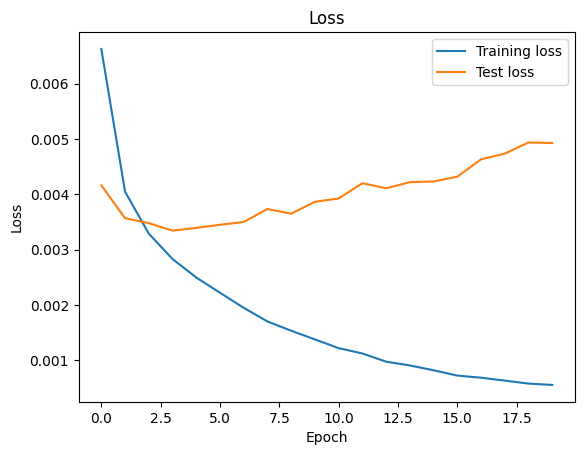

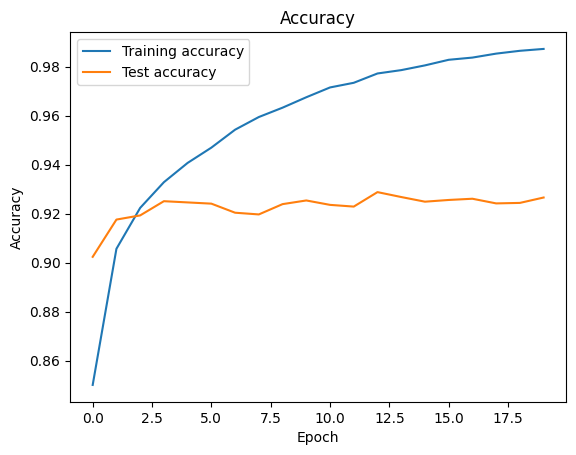

([0.006628888461366296,
  0.004050127328187227,
  0.0032918867767478027,
  0.0028329693249116343,
  0.002498950139557322,
  0.0022240116639994085,
  0.0019515391190846761,
  0.0017051432008389383,
  0.001537597083292591,
  0.0013805040813516826,
  0.0012230507125069077,
  0.001126457365237487,
  0.0009783721938651675,
  0.0009105927045030209,
  0.0008234976720142489,
  0.0007271881211063979,
  0.0006889903361792676,
  0.0006362979247700423,
  0.0005824021098659917,
  0.000558413439715514],
 [0.004164631046354771,
  0.003569408562965691,
  0.0034819142051041125,
  0.003345695332810283,
  0.003395435877889395,
  0.003450921545550227,
  0.0035033880464732645,
  0.003735934467613697,
  0.003652143419161439,
  0.0038672610197216274,
  0.003926567736687139,
  0.004202476349007338,
  0.0041114532598294316,
  0.004221316849999129,
  0.004234069537743926,
  0.004320181996747851,
  0.004634419105015695,
  0.004736852691788226,
  0.004938629141449928,
  0.004929237209074199],
 [0.85015,
  0.90568

In [62]:
model = torchvision.models.resnet18(pretrained=True)
model.fc = nn.Linear(512, 10)
model.to(device)

lr_init = 0.001
lr_factor = 0.1
weight_decay_factor = 1e-4
lr_schedule_milestones = [50e3, 75e3, 100e3]
epochs = 20

criterion = nn.CrossEntropyLoss()

optimizer = optim.SGD(model.parameters(), lr=lr_init, momentum=0.9, weight_decay=weight_decay_factor)
lr_scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=lr_schedule_milestones, gamma=lr_factor)

run_training(model, criterion, optimizer, epochs, lr_scheduler)